## Pre-imputation data comparison

The purpose of this is to compare the inputs from Ayako for imputation vs what we've got
for imputation.

In [ ]:
import polars as pl
import tempfile
import zipfile
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from matplotlib.colors import TwoSlopeNorm
import math

# Load the india grid
with tempfile.TemporaryDirectory() as tmpdir:
    zip_path = Path("../../grid_india_10km_shapefiles.zip")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(tmpdir)
        grid_path = Path(tmpdir, "grid_india_10km", "grid_india_10km.shp")
        
        grid = gpd.read_file(grid_path)
        # Convert grid_id to int and then to string
        grid["grid_id"] = grid["grid_id"].astype(int).astype(str)


### Loading the data
Load the expected (Ayako's) and actual (ours), and join it so we can easily compare across them.

In [21]:
expected = pl.read_parquet(
    "inputs/expected_imputation_2023_01"
)

# Convert date to string "YYYY-MM-DD"
expected = expected.with_columns(
    pl.col("date").dt.strftime("%Y-%m-%d").alias("date"),
)

actual = pl.read_parquet(
    "gs://crea-pm25ml-examples/combined__omi_full_nn.parquet"
)

# Join expected and actual dataframes on 'date' and 'grid_id'
joined = (
    expected
        .join(
            actual,
            on=["date", "grid_id"],
            how="full",
            suffix="_actual",
        )
        .sort(["grid_id", "date"])
        .with_columns(
            pl.col("date").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("date")
        )
)

In [22]:
joined.columns

['grid_id',
 'date',
 'aot_daily',
 'co_daily',
 'omi_no2',
 'v_wind',
 'u_wind',
 'rainfall',
 'temp',
 'pressure',
 'thermal_radiation',
 'low_veg',
 'high_veg',
 'dewpoint_temp',
 'NO2_tropos',
 'NO2_missing',
 'aod',
 'aod_missing',
 'CO',
 'CO_missing',
 'elevation',
 'water',
 'shurub',
 'urban',
 'forest',
 'savannas',
 'month',
 'day_of_year',
 'cos_day_of_year',
 'monsoon',
 'lon',
 'lat',
 'wind_degree',
 'RH',
 'aot_rolling',
 'co_rolling',
 'omi_no2_rolling',
 'v_wind_rolling',
 'u_wind_rolling',
 'rainfall_rolling',
 'temp_rolling',
 'pressure_rolling',
 'wind_degree_rolling',
 'RH_rolling',
 'thermal_radiation_rolling',
 'dewpoint_temp_rolling',
 'aot_daily_annual',
 'co_daily_annual',
 'omi_no2_annual',
 'v_wind_annual',
 'u_wind_annual',
 'rainfall_annual',
 'temp_annual',
 'pressure_annual',
 'thermal_radiation_annual',
 'low_veg_annual',
 'high_veg_annual',
 'dewpoint_temp_annual',
 'wind_degree_annual',
 'RH_annual',
 'aot_daily_allyears',
 'co_daily_allyears',
 'omi

Add some computed columns for comparison.

In [23]:
rolling_days = 7

joined = joined.with_columns(
    omi_no2__no2_rolling_mean=pl.col("omi_no2__no2")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_rolling_mean=pl.col("omi_no2_v4__no2")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2__no2_temporal_interpolated=pl.col("omi_no2__no2").fill_nan(None).interpolate(method="linear").over("grid_id"),
    omi_no2_v4__no2_temporal_interpolated=pl.col("omi_no2_v4__no2").fill_nan(None).interpolate(method="linear").over("grid_id"),
    # Okay, instead of interpolating, can we just fill forward?
    omi_no2__no2_filled_forward=pl.col("omi_no2__no2").fill_nan(None).fill_null(strategy="forward").over("grid_id"),
    omi_no2_v4__no2_filled_forward=pl.col("omi_no2_v4__no2").fill_nan(None).fill_null(strategy="forward").over("grid_id"),
    omi_no2__no2_cloud_screened_rolling_mean=pl.col("omi_no2__no2_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2__no2_trop_rolling_mean=pl.col("omi_no2__no2_trop")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2__no2_trop_cloud_screened_rolling_mean=pl.col("omi_no2__no2_trop_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_cloud_screened_rolling_mean=pl.col("omi_no2_v4__no2_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_trop_rolling_mean=pl.col("omi_no2_v4__no2_trop")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_trop_cloud_screened_rolling_mean=pl.col("omi_no2_v4__no2_trop_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
)

Also load to a pandas GeoDataFrame.

In [24]:
# Convert joined to pandas
joined_pd = joined.to_pandas()
grid = grid.copy()
grid.reset_index(inplace=True)
# Set grid_id as index
joined_pd["grid_id"] = joined_pd["grid_id"].astype(int)
grid["grid_id"] = grid["grid_id"].astype(int)
joined_pd.set_index("grid_id", inplace=True)
grid.set_index("grid_id", inplace=True)

# Join to the grid by grid_id
joined_gdf = grid.join(
    joined_pd,
    on="grid_id",
    how="left",
)
joined_gdf = joined_gdf.to_crs("EPSG:4326")  # Convert to WGS84

In [25]:
india_gdf = joined_gdf.to_crs(epsg=7755)

## Detailed comparison

To start, we're just going to compare the expected columns to actual columns. I'm
excluding:
 - AOD - because there's no data in the comparison set
 - land cover - because we have already identified a bug in that code.


In [26]:
column_maps = [
    # (<our_column>, <expected_column>)
    ("era5_land__temperature_2m", "temp"),
    ("era5_land__dewpoint_temperature_2m", "dewpoint_temp"),
    ("era5_land__u_component_of_wind_10m", "u_wind"),
    ("era5_land__v_component_of_wind_10m", "v_wind"),
    ("era5_land__total_precipitation_sum", "rainfall"),
    ("era5_land__surface_net_thermal_radiation_sum", "thermal_radiation"),
    ("era5_land__surface_pressure", "pressure"),
    ("era5_land__leaf_area_index_high_vegetation", "high_veg"),
    ("era5_land__leaf_area_index_low_vegetation", "low_veg"),
    ("merra_aot__aot", "aot_daily"),
    ("merra_co__co", "co_daily"),
    ("merra_co_top__co", "co_daily"),
    ("omi_no2__no2", "omi_no2"),
    ("s5p_no2__tropospheric_NO2_column_number_density", "NO2_tropos"),
    ("s5p_co__CO_column_number_density", "CO"),
    ("grid__lat", "lat"),
    ("grid__lon", "lon"),
]

for expected_col, actual_col in column_maps:
    if expected_col not in joined.columns:
        raise ValueError(f"Expected column '{expected_col}' not found in joined DataFrame.")
    if actual_col not in joined.columns:
        raise ValueError(f"Actual column '{actual_col}' not found in joined DataFrame.")


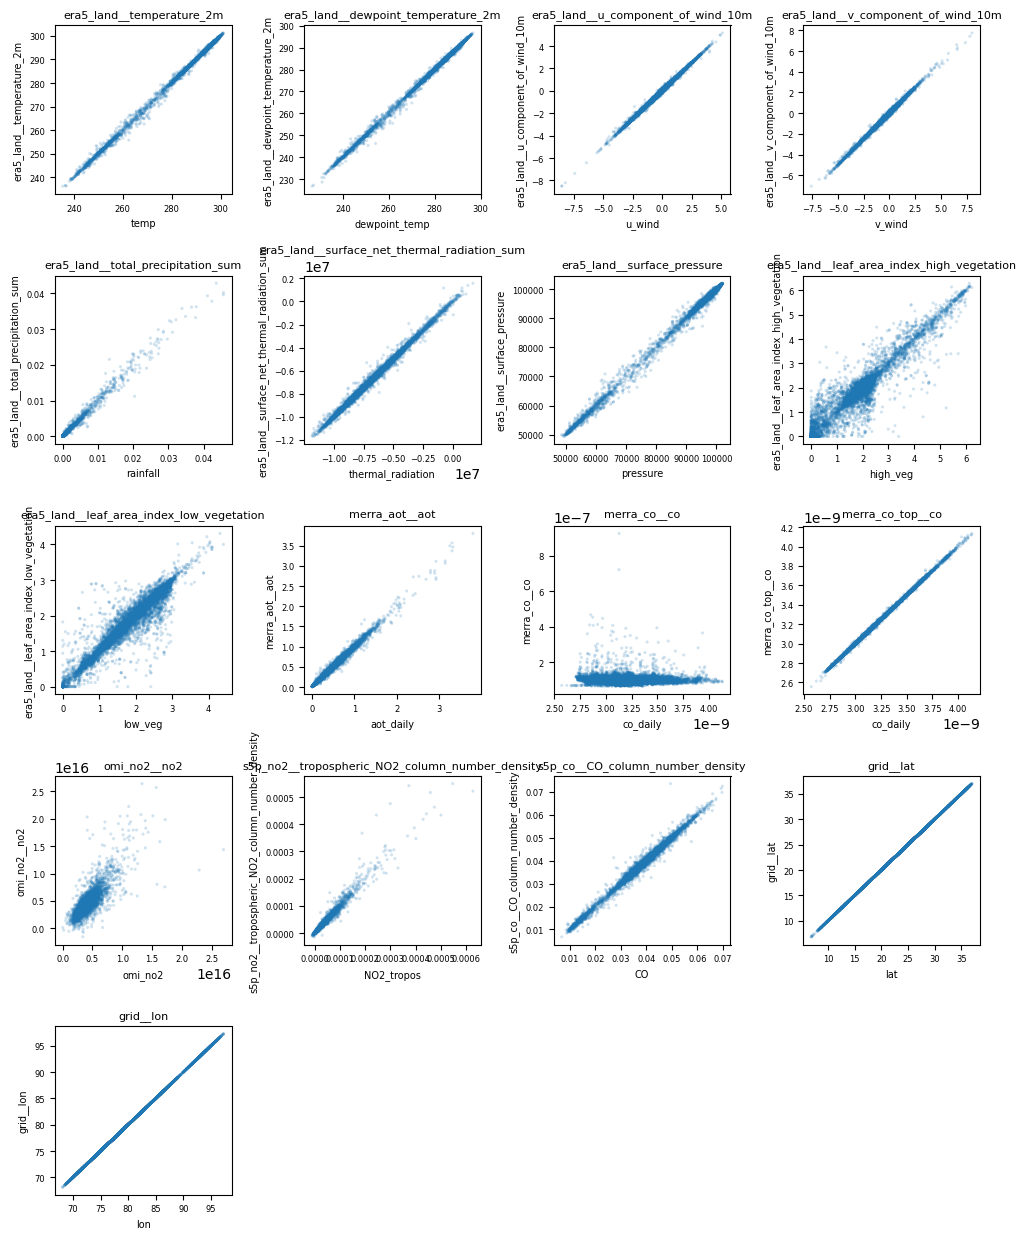

In [27]:

ncols = 4
nrows = -(-len(column_maps) // ncols)  # Ceiling division for rows

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2.5, nrows * 2.5))
axes = axes.flatten()

sampled_joined = joined.sample(n=10000, seed=42)

for ax, (actual_col, expected_col) in zip(axes, column_maps):
    if expected_col in sampled_joined.columns and actual_col in sampled_joined.columns:
        ax.scatter(
            sampled_joined[expected_col],
            sampled_joined[actual_col],
            s=5,
            alpha=0.2,
            edgecolors='none'
        )
        ax.set_title(f"{actual_col}")
        # Make the title smaller
        ax.title.set_fontsize(8)
    
        ax.set_xlabel(expected_col)
        ax.set_ylabel(actual_col)
        # Make the x and y labels smaller
        ax.xaxis.label.set_fontsize(7)
        ax.yaxis.label.set_fontsize(7)
        # Also make the tick labels smaller
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=6)
    else:
        ax.set_visible(False)  # Hide unused axes if columns are missing

# Hide any leftover unused subplots
for ax in axes[len(column_maps):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


Looking at the visual comparisons, that leaves the following as ones to investigate:
- OMI NO2
- leaf area index columns

In [28]:
# We only want to plot bad columns
bad_column_maps = [
    ("omi_no2__no2", "omi_no2"),
    ("omi_no2_v4__no2", "omi_no2"),
    ("omi_no2__no2_rolling_mean", "omi_no2"),
    ("omi_no2_v4__no2_rolling_mean", "omi_no2"),
    ("omi_no2__no2_cloud_screened", "omi_no2"),
    ("omi_no2_v4__no2_cloud_screened", "omi_no2"),
    ("omi_no2__no2_trop", "omi_no2"),
    ("omi_no2_v4__no2_trop", "omi_no2"),
    ("omi_no2__no2_trop_cloud_screened", "omi_no2"),
    ("omi_no2_v4__no2_trop_cloud_screened", "omi_no2"),
]

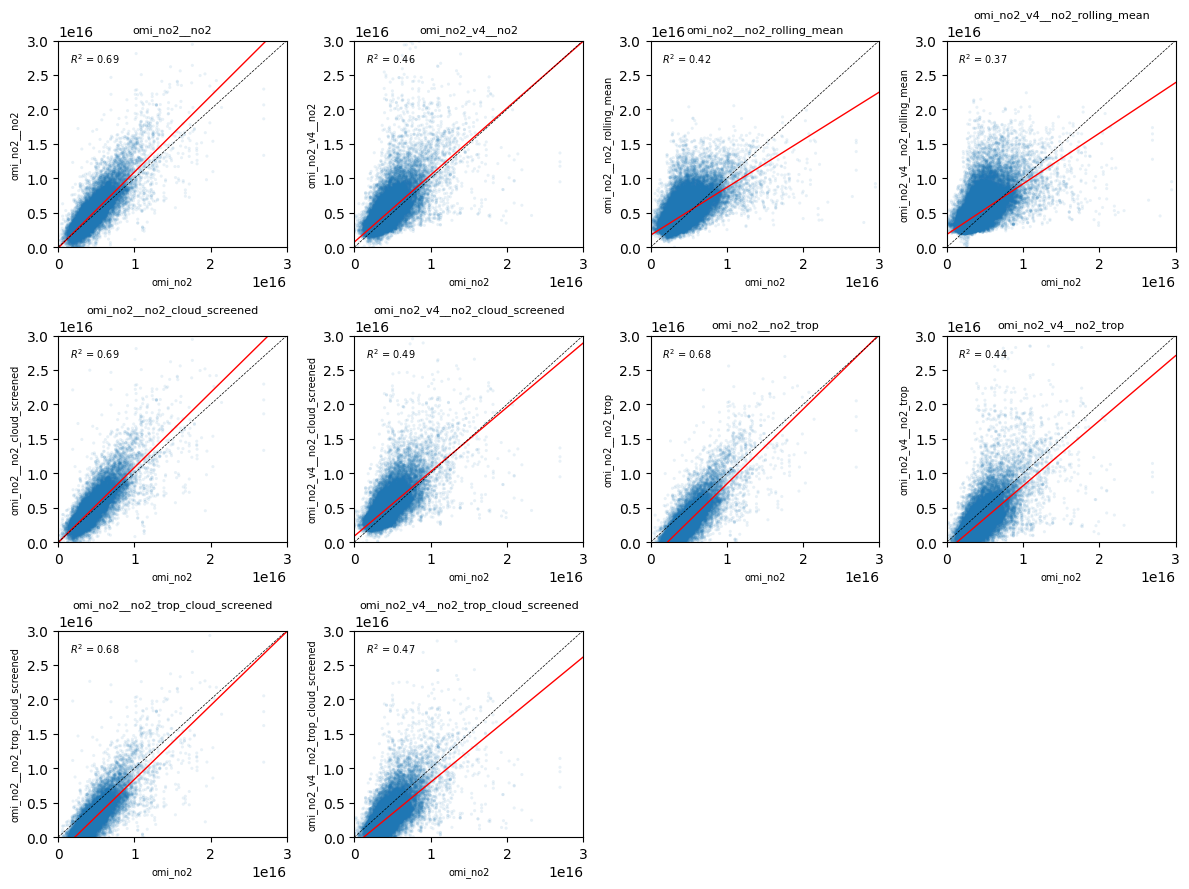

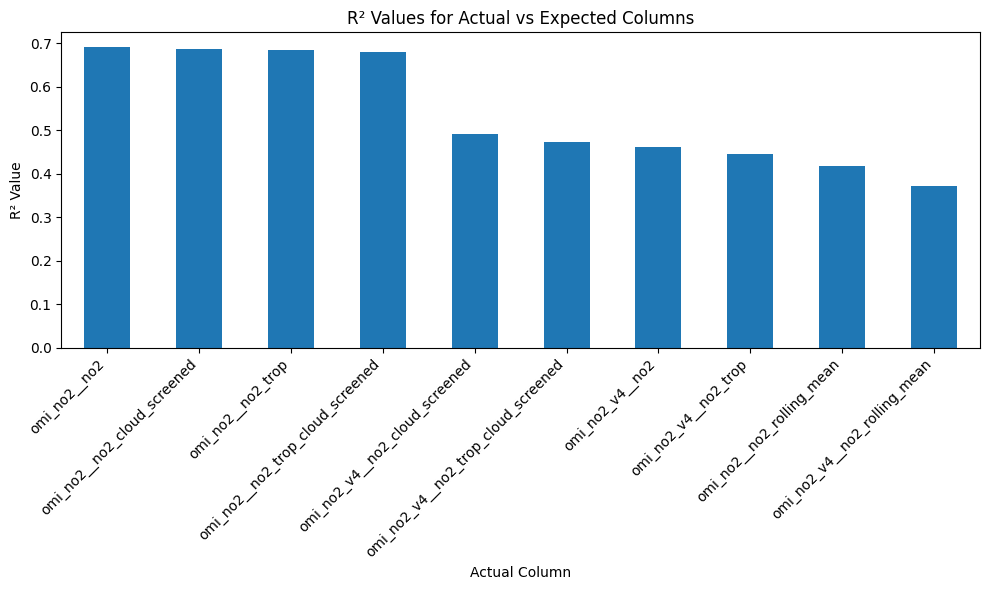

In [29]:

import datetime 


ncols = 4
nrows = -(-len(bad_column_maps) // ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
axes = axes.flatten()

data_after_rolling = joined.filter(pl.col("date") > datetime.date(2023, 1, 5), pl.col("date") < datetime.date(2023, 1, 25))

sampled_joined = data_after_rolling.sample(n=100000, seed=42)

omi_xmax = 3e16
omi_ymax = 3e16
omi_xmin = 0
omi_ymin = 0

r2_results = []

for ax, (actual_col, expected_col) in zip(axes, bad_column_maps):
    if expected_col in sampled_joined.columns and actual_col in sampled_joined.columns:
        ax.scatter(
            sampled_joined[expected_col],
            sampled_joined[actual_col],
            s=5,
            alpha=0.1,
            edgecolors='none',
        )
        ax.set_xlim(omi_xmin, omi_xmax)
        ax.set_ylim(omi_ymin, omi_ymax)
        ax.set_title(f"{actual_col}")
        # Make the title smaller
        ax.title.set_fontsize(8)
    
        ax.set_xlabel(expected_col)
        ax.set_ylabel(actual_col)
        # Make the x and y labels smaller
        ax.xaxis.label.set_fontsize(7)
        ax.yaxis.label.set_fontsize(7)

        valid_sampled = sampled_joined.select(
            expected_col, actual_col
        ).drop_nans().drop_nulls()

        slope, intercept = np.polyfit(valid_sampled[expected_col], valid_sampled[actual_col], 1)
        x_line = np.array([omi_xmin, omi_xmax])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, color='red', linewidth=1, label='Linear fit')

        y_vals = valid_sampled[actual_col].to_numpy()
        x_vals = valid_sampled[expected_col].to_numpy()
        residuals = y_vals - (slope * x_vals + intercept)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_vals - np.mean(y_vals))**2)
        r_squared = 1 - (ss_res / ss_tot)

        r2_results.append((actual_col, expected_col, r_squared))

        # Annotate plot with R²
        ax.text(0.05, 0.95, f"$R^2$ = {r_squared:.2f}",
                transform=ax.transAxes,
                fontsize=7,
                verticalalignment='top')

        x_line = np.array([omi_xmin, omi_xmax])
        y_line = np.array([omi_ymin, omi_ymax])
        ax.plot(x_line, y_line, color='black', linewidth=0.5, linestyle='--', label='y=x line')
        
    else:
        ax.set_visible(False)  # Hide unused axes if columns are missing

# Hide any leftover unused subplots
for ax in axes[len(bad_column_maps):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Show R² results as chart
import pandas as pd

r2_df = pd.DataFrame(r2_results, columns=["actual_col", "expected_col", "r_squared"])
r2_df = r2_df.sort_values(by="r_squared", ascending=False)
r2_df.set_index("actual_col", inplace=True)
r2_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title("R² Values for Actual vs Expected Columns")
plt.xlabel("Actual Column")
plt.ylabel("R² Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### OMI NO2


First, this confirms that `omi_no2_rolling` is `omi_no2` with a 7-day rolling average:

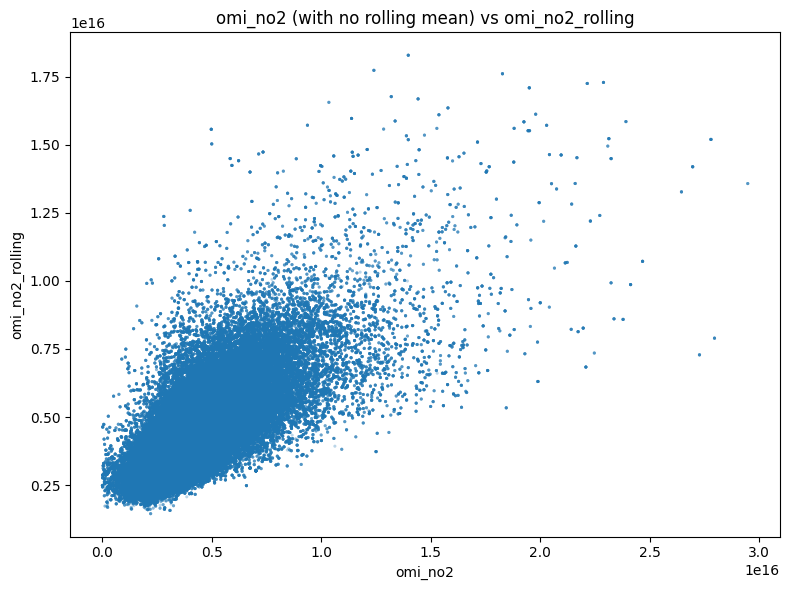

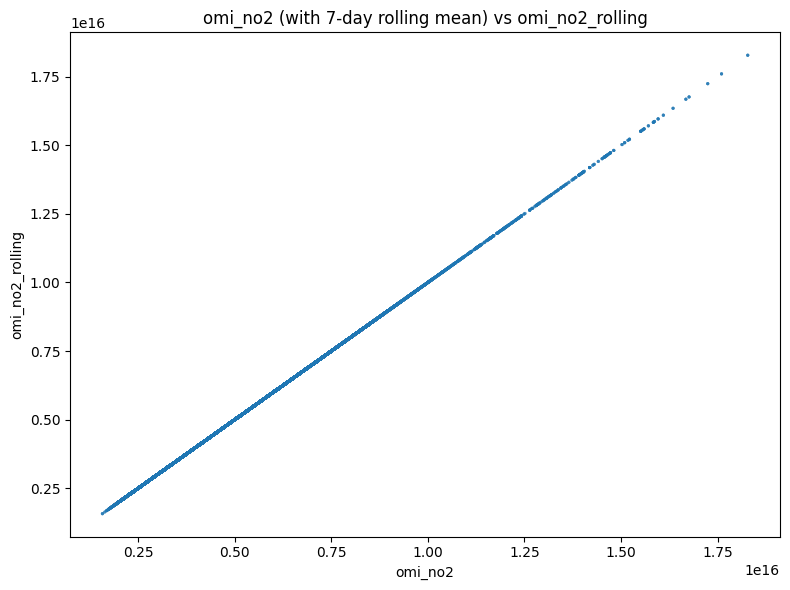

In [30]:
# Compare just omi_no2 vs omi_no2_rolling

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    joined["omi_no2"],
    joined["omi_no2_rolling"],
    s=5,
    alpha=0.3,
    edgecolors="none"
)
ax.set_xlabel("omi_no2")
ax.set_ylabel("omi_no2_rolling")
ax.set_title("omi_no2 (with no rolling mean) vs omi_no2_rolling")
plt.tight_layout()
plt.show()

omi_no2_7_day_rolling = joined.with_columns(
    omi_no2_7_day_rolling = pl.col("omi_no2")
        .fill_nan(None)
        .rolling_mean(window_size=7, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=True)
).filter(pl.col("date") > date(2023, 1, 4), pl.col("date") < date(2023, 1, 27))


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    omi_no2_7_day_rolling["omi_no2_7_day_rolling"],
    omi_no2_7_day_rolling["omi_no2_rolling"],
    s=5,
    alpha=0.3,
    edgecolors="none"
)
ax.set_xlabel("omi_no2")
ax.set_ylabel("omi_no2_rolling")
ax.set_title("omi_no2 (with 7-day rolling mean) vs omi_no2_rolling")
plt.tight_layout()
plt.show()

# Compare just omi_no2 vs omi_no2_rolling


Next, we're going to try to identify which of our columns have the minimum MSE
between our columns and Ayako's columns.

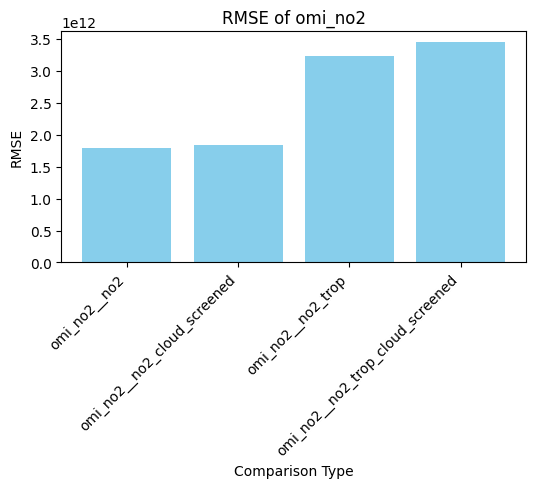

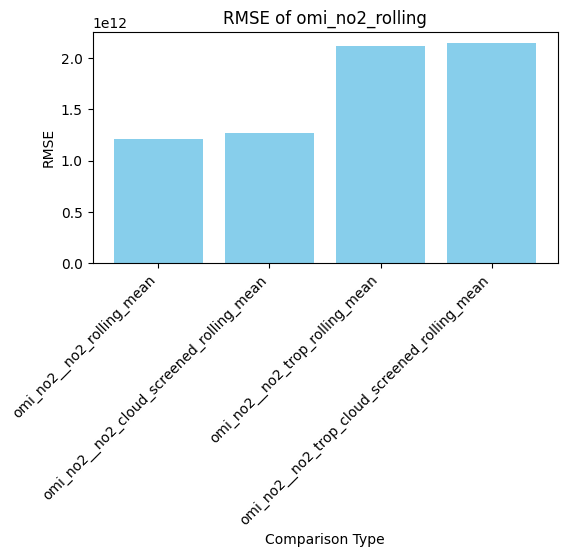

In [31]:
# Calculate, for each of these the mean squared error
from typing import cast


def plot_column_comparison(
    columns: list[tuple[str, str]],
    title: str,
):
    mse_results = {}

    for actual_col, expected_col in columns:
        comparison_name = actual_col
        if expected_col in joined.columns and actual_col in joined.columns:
            filtered_rows = joined.select(
                expected_col, actual_col
            ).drop_nulls().drop_nans()
            rmse = (
                (filtered_rows[expected_col] - filtered_rows[actual_col]) ** 2
            ).mean()
            mse_results[comparison_name] = math.sqrt(cast("float", rmse) / filtered_rows.shape[0])
        else:
            mse_results[comparison_name] = None  # Handle missing columns

    # Plot the omi_no2 comparisons against each other

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.bar(list(mse_results.keys()), list(mse_results.values()), color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Comparison Type')
    ax.set_ylabel('RMSE')
    ax.set_xticks(range(len(mse_results)))
    ax.set_xticklabels(list(mse_results.keys()), rotation=45, ha='right')


plot_column_comparison([
    ("omi_no2__no2", "omi_no2"),
    ("omi_no2__no2_cloud_screened", "omi_no2"),
    ("omi_no2__no2_trop", "omi_no2"),
    ("omi_no2__no2_trop_cloud_screened", "omi_no2"),
    
], "RMSE of omi_no2")
plot_column_comparison([
    ("omi_no2__no2_rolling_mean", "omi_no2_rolling"),
    ("omi_no2__no2_cloud_screened_rolling_mean", "omi_no2_rolling"),
    ("omi_no2__no2_trop_rolling_mean", "omi_no2_rolling"),
    ("omi_no2__no2_trop_cloud_screened_rolling_mean", "omi_no2_rolling"),
    
], "RMSE of omi_no2_rolling")

For OMI NO2, these look like the best comparisons are:
- for `omi_no2` it matches best with `omi_no2__no2` or `omi_no2__no2_cloud_screened`
- for `omi_no2_rolling` it matches best with `omi_no2__no2_rolling_mean` or `omi_no2__no2_cloud_screened_rolling_mean`

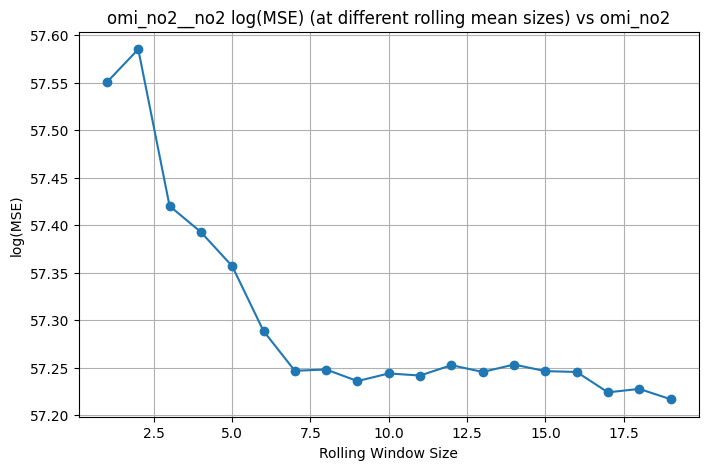

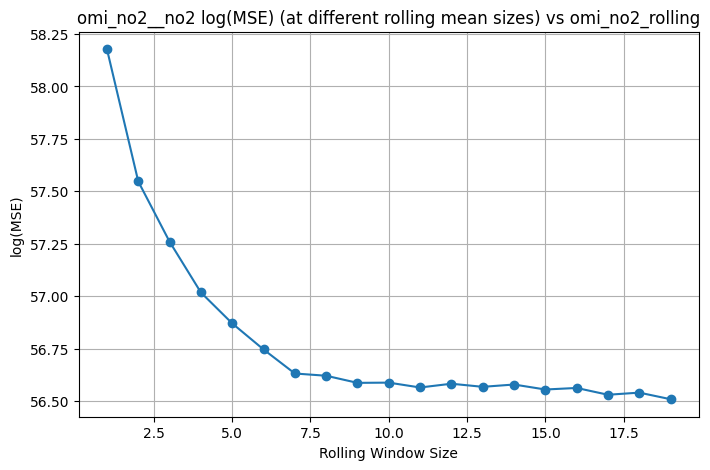

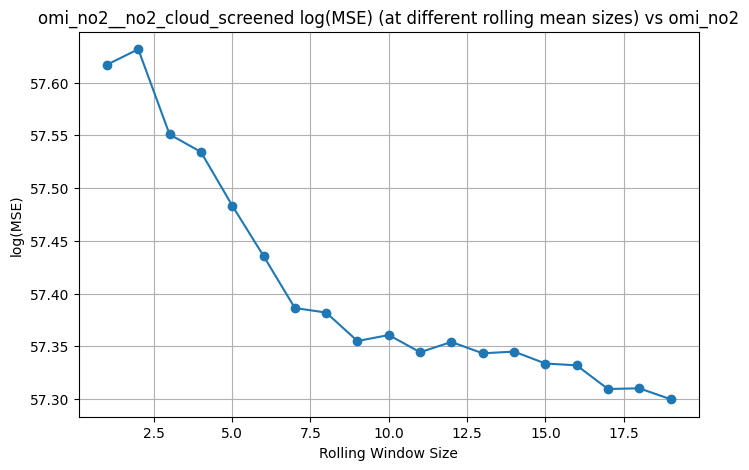

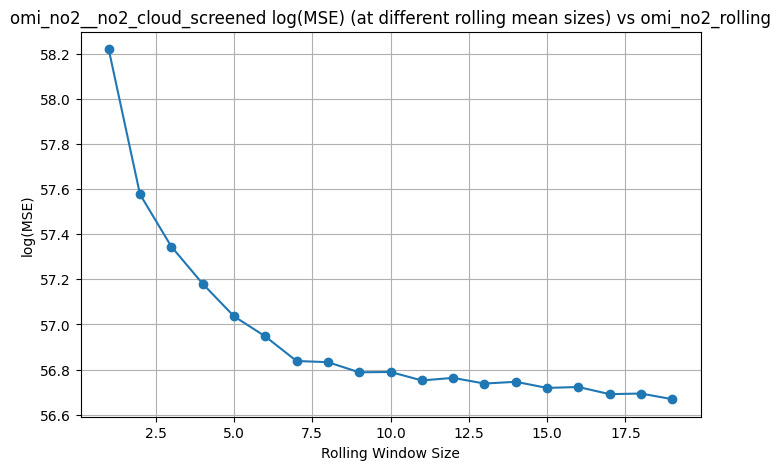

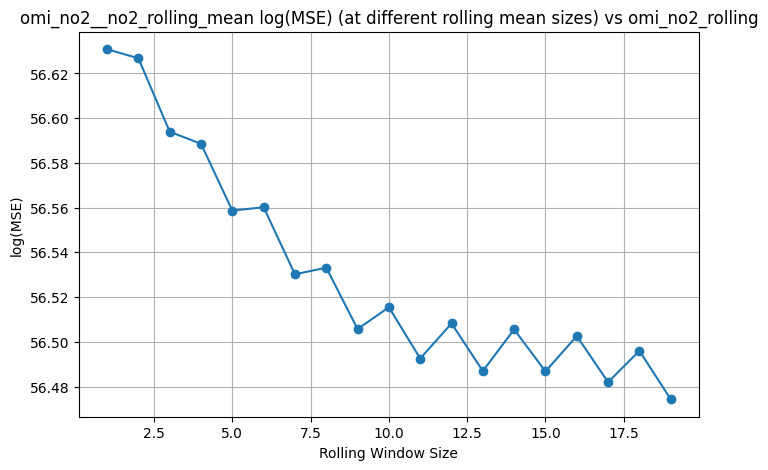

In [32]:

import math


def plot_comparison_different_window_sizes(
    base_column: str,
    comparison_column: str,
):
    errors = []

    for i in range(1, 20):
        omi_no2_more_rolling = joined.with_columns(
            omi_no2__no2_rolling = pl.col(base_column)
                .fill_nan(None)
                .rolling_mean(window_size=i, min_samples=1, center=True)
                .over("grid_id", order_by="date", descending=True)
        ).filter(pl.col("date") > date(2023, 1, 10), pl.col("date") < date(2023, 1, 20))

        filtered_rows = omi_no2_more_rolling.select(
            "omi_no2__no2_rolling", comparison_column
        ).drop_nulls().drop_nans()

        diff = filtered_rows["omi_no2__no2_rolling"] - filtered_rows[comparison_column]
        err = math.log(cast("float", (diff ** 2).mean()) / float(filtered_rows.shape[0]))
        errors += [(i, err)]

    window_sizes, mse_values = zip(*errors)
    plt.figure(figsize=(8, 5))
    plt.plot(window_sizes, mse_values, marker='o')
    plt.xlabel("Rolling Window Size")
    plt.ylabel("log(MSE)")
    plt.title(f"{base_column} log(MSE) (at different rolling mean sizes) vs {comparison_column}")
    plt.grid(True)
    plt.show()

plot_comparison_different_window_sizes("omi_no2__no2", "omi_no2")
plot_comparison_different_window_sizes("omi_no2__no2", "omi_no2_rolling")
plot_comparison_different_window_sizes("omi_no2__no2_cloud_screened", "omi_no2")
plot_comparison_different_window_sizes("omi_no2__no2_cloud_screened", "omi_no2_rolling")
plot_comparison_different_window_sizes("omi_no2__no2_rolling_mean", "omi_no2_rolling")


#### Mapping the data

We're going to map the data spatially to see what it looks like, in comparison.

First, we're mapping for the middle of the month, comparing `omi_no2`,
`omi_no2_rolling`, `omi_no2__no2`, and `omi_no2__no2_rolling_mean`.

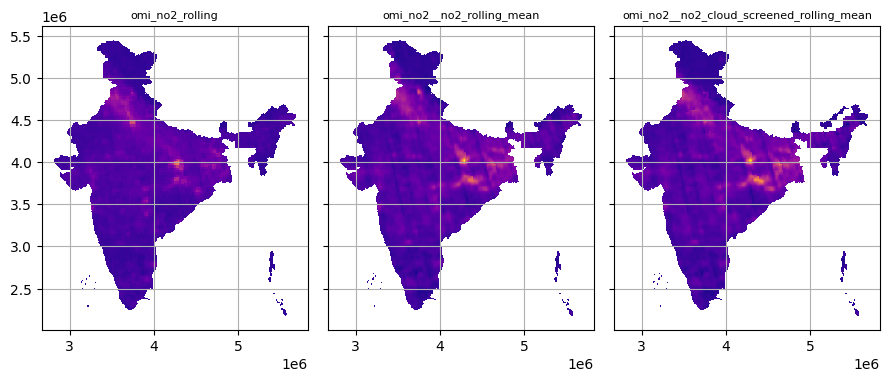

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(9, 12), sharex=True, sharey=True)

gdf_for_date = india_gdf[india_gdf['date'] == '2023-01-15']

charts_to_plot = [
    'omi_no2_rolling',
    'omi_no2__no2_rolling_mean',
    'omi_no2__no2_cloud_screened_rolling_mean',
]

# Plot each column in the specified layout
vmin = min(gdf_for_date[charts_to_plot].min().min(), gdf_for_date[charts_to_plot].max().max())
vmax = max(gdf_for_date[charts_to_plot].max().max(), gdf_for_date[charts_to_plot].min().min())

# Plot the data
for idx, column in enumerate(charts_to_plot):
    gdf_for_date.plot(
        ax=axes[idx],
        column=column,
        cmap='plasma',
        vmin=vmin,
        vmax=vmax,
        markersize=0,
        linewidth=0,
    )
    axes[idx].set_title(column)
    axes[idx].title.set_fontsize(8)
    axes[idx].grid(True)

plt.tight_layout()
plt.show()


Next, we're mapping a month average.

In [43]:
monthly_avg = gpd.GeoDataFrame(
    india_gdf
        # For a fair comparison, we want to filter out the dates that would fall outside the
        # moving average window for omi_no2__no2_rolling_mean
        [(india_gdf["date"] >= "2023-01-10") & (india_gdf["date"] < "2023-02-20")]
        .drop(columns=["date", "date_actual", "index"])
        .groupby(['grid_id', 'geometry'])
        .mean()
        .reset_index()
)

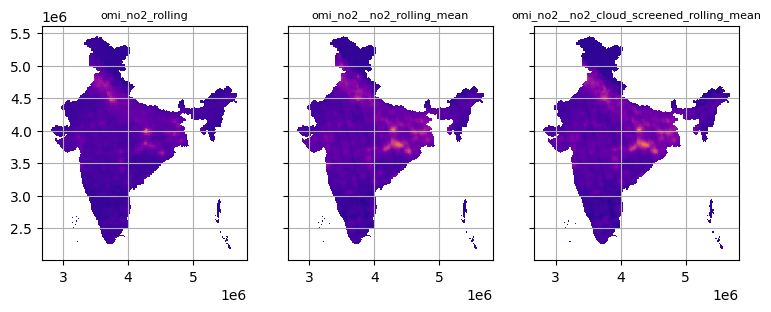

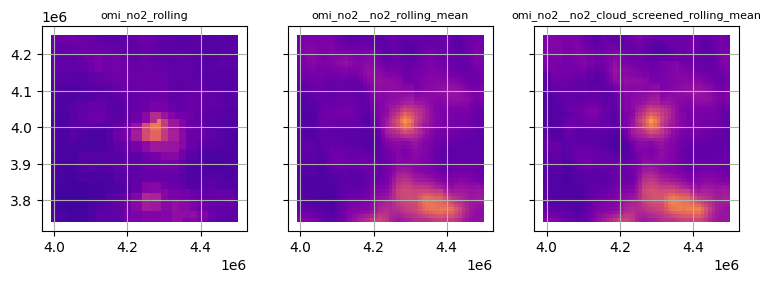

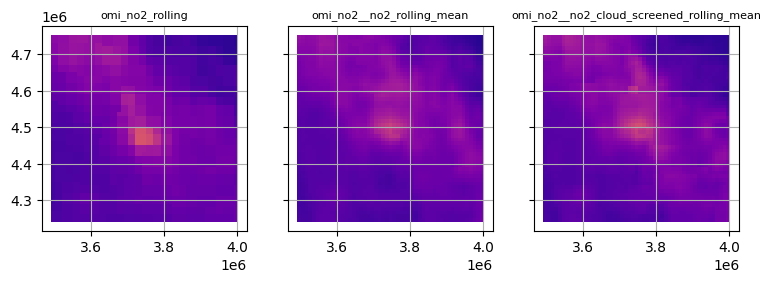

In [44]:

fig, axes = plt.subplots(1, 3, figsize=(9, 12), sharex=True, sharey=True)

vmin = min(gdf_for_date[charts_to_plot].min().min(), gdf_for_date[charts_to_plot].max().max())
vmax = max(gdf_for_date[charts_to_plot].max().max(), gdf_for_date[charts_to_plot].min().min())


# Plot each column in the specified layout
for idx, column in enumerate(charts_to_plot):
    monthly_avg.plot(
        ax=axes[idx],
        column=column,
        cmap='plasma',
        markersize=0,
        linewidth=0,
        vmin=vmin,
        vmax=vmax,
    )
    axes[idx].set_title(column)
    axes[idx].title.set_fontsize(8)
    axes[idx].grid(True)

fig, axes = plt.subplots(1, 3, figsize=(9, 12), sharex=True, sharey=True)

zoomed = monthly_avg.cx[4e6:4.5e6, 3.75e6:4.25e6]

# Plot each column in the specified layout
for idx, column in enumerate(charts_to_plot):
    zoomed.plot(
        ax=axes[idx],
        column=column,
        cmap='plasma',
        markersize=0,
        linewidth=0,
        vmin=vmin,
        vmax=vmax,
    )
    axes[idx].set_title(column)
    axes[idx].title.set_fontsize(8)
    axes[idx].grid(True)

fig, axes = plt.subplots(1, 3, figsize=(9, 12), sharex=True, sharey=True)

zoomed = monthly_avg.cx[3.5e6:4e6, 4.25e6:4.75e6]

# Plot each column in the specified layout
for idx, column in enumerate(charts_to_plot):
    zoomed.plot(
        ax=axes[idx],
        column=column,
        cmap='plasma',
        markersize=0,
        linewidth=0,
        vmin=vmin,
        vmax=vmax,
    )
    axes[idx].set_title(column)
    axes[idx].title.set_fontsize(8)
    axes[idx].grid(True)

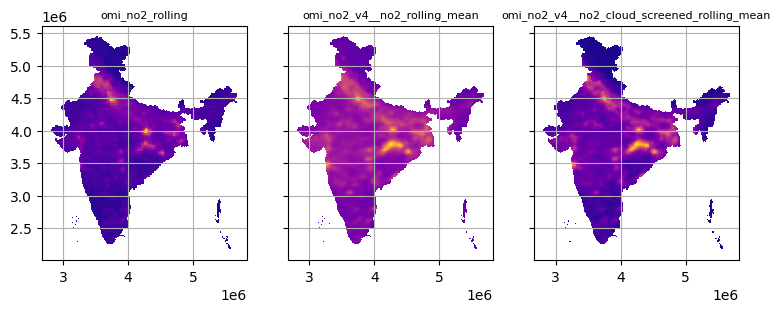

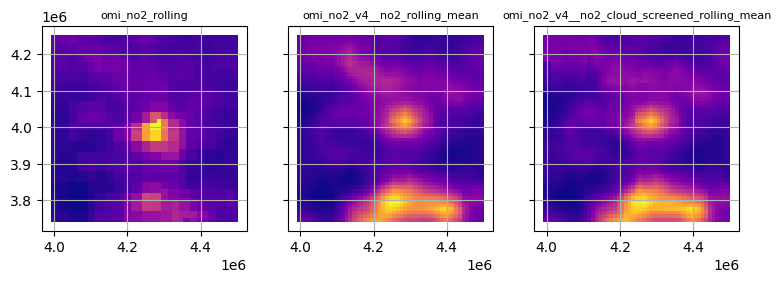

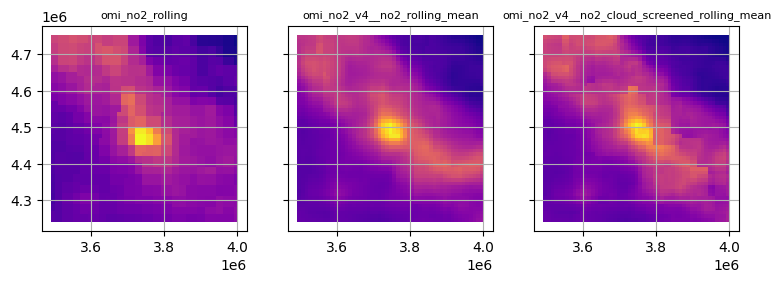

In [36]:

fig, axes = plt.subplots(1, 3, figsize=(9, 12), sharex=True, sharey=True)

charts_to_plot_tmp = [
    'omi_no2_rolling',
    'omi_no2_v4__no2_rolling_mean',
    'omi_no2_v4__no2_cloud_screened_rolling_mean',
]

# Plot each column in the specified layout
for idx, column in enumerate(charts_to_plot_tmp):
    monthly_avg.plot(
        ax=axes[idx],
        column=column,
        cmap='plasma',
        markersize=0,
        linewidth=0,
    )
    axes[idx].set_title(column)
    axes[idx].title.set_fontsize(8)
    axes[idx].grid(True)

fig, axes = plt.subplots(1, 3, figsize=(9, 12), sharex=True, sharey=True)

zoomed = monthly_avg.cx[4e6:4.5e6, 3.75e6:4.25e6]

# Plot each column in the specified layout
for idx, column in enumerate(charts_to_plot_tmp):
    zoomed.plot(
        ax=axes[idx],
        column=column,
        cmap='plasma',
        markersize=0,
        linewidth=0,
    )
    axes[idx].set_title(column)
    axes[idx].title.set_fontsize(8)
    axes[idx].grid(True)

fig, axes = plt.subplots(1, 3, figsize=(9, 12), sharex=True, sharey=True)

zoomed = monthly_avg.cx[3.5e6:4e6, 4.25e6:4.75e6]

# Plot each column in the specified layout
for idx, column in enumerate(charts_to_plot_tmp):
    zoomed.plot(
        ax=axes[idx],
        column=column,
        cmap='plasma',
        markersize=0,
        linewidth=0,
    )
    axes[idx].set_title(column)
    axes[idx].title.set_fontsize(8)
    axes[idx].grid(True)

Zooming into a particular area, it looks like this is translated.

In [37]:
translated_geom_monthly = monthly_avg.copy().to_crs("EPSG:4326").geometry.translate(-0.125, -0.125)
translated_india_gdf_monthly = gpd.GeoDataFrame(monthly_avg.copy(), geometry=translated_geom_monthly, crs="EPSG:4326").to_crs(epsg=7755)


In [38]:
omi_translated_joined = gpd.sjoin_nearest(
    monthly_avg[["omi_no2", "omi_no2_rolling", "geometry"]],
    translated_india_gdf_monthly[[
        "omi_no2__no2_rolling_mean",
        "omi_no2__no2_cloud_screened_rolling_mean",
        "omi_no2__no2_trop_rolling_mean",
        "omi_no2__no2_trop_cloud_screened_rolling_mean",
        "geometry"
    ]],
    how="inner",
    distance_col="dist",
    max_distance=10000,
)

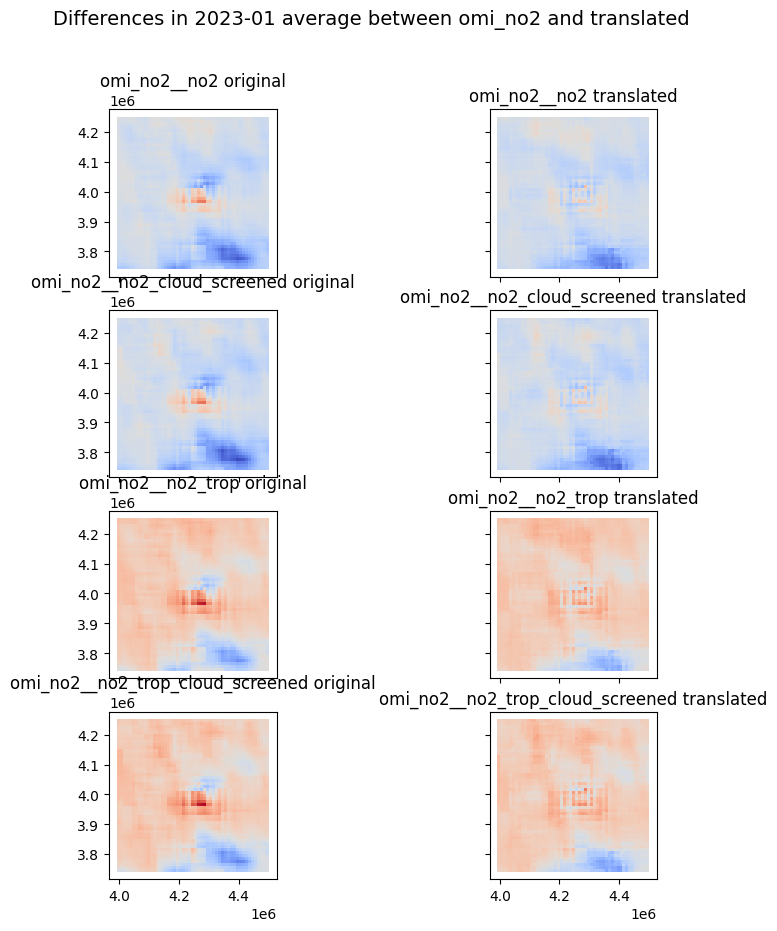

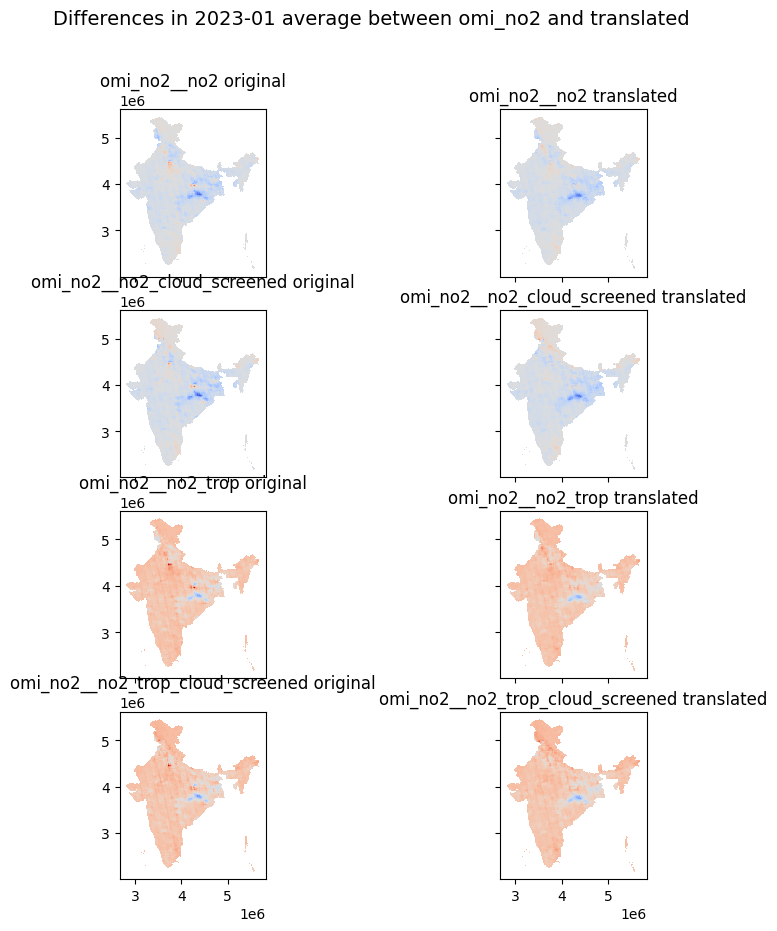

In [39]:
# Convert each of these to rasters and then take a difference

omi_translated_joined_diffs = omi_translated_joined.assign(
    omi_no2__no2_diff=omi_translated_joined["omi_no2_rolling"] - omi_translated_joined["omi_no2__no2_rolling_mean"],
    omi_no2__no2_cloud_screened_diff=omi_translated_joined["omi_no2_rolling"] - omi_translated_joined["omi_no2__no2_cloud_screened_rolling_mean"],
    omi_no2__no2_trop_diff=omi_translated_joined["omi_no2_rolling"] - omi_translated_joined["omi_no2__no2_trop_rolling_mean"],
    omi_no2__no2_trop_cloud_screened_diff=omi_translated_joined["omi_no2_rolling"] - omi_translated_joined["omi_no2__no2_trop_cloud_screened_rolling_mean"],
)

original_diffs = monthly_avg.assign(
    omi_no2__no2_diff=monthly_avg["omi_no2_rolling"] - monthly_avg["omi_no2__no2_rolling_mean"],
    omi_no2__no2_cloud_screened_diff=monthly_avg["omi_no2_rolling"] - monthly_avg["omi_no2__no2_cloud_screened_rolling_mean"],
    omi_no2__no2_trop_diff=monthly_avg["omi_no2_rolling"] - monthly_avg["omi_no2__no2_trop_rolling_mean"],
    omi_no2__no2_trop_cloud_screened_diff=monthly_avg["omi_no2_rolling"] - monthly_avg["omi_no2__no2_trop_cloud_screened_rolling_mean"],
)

# Plot the differences
fig, axes = plt.subplots(4, 2, figsize=(9, 10), sharex=True, sharey=True)
fig.suptitle("Differences in 2023-01 average between omi_no2 and translated", fontsize=14)

vmin = min(
    omi_translated_joined_diffs["omi_no2__no2_diff"].min(),
    original_diffs["omi_no2__no2_diff"].min(),
    omi_translated_joined_diffs["omi_no2__no2_cloud_screened_diff"].min(),
    original_diffs["omi_no2__no2_cloud_screened_diff"].min(),
    omi_translated_joined_diffs["omi_no2__no2_trop_diff"].min(),
    original_diffs["omi_no2__no2_trop_diff"].min(),
    omi_translated_joined_diffs["omi_no2__no2_trop_cloud_screened_diff"].min(),
    original_diffs["omi_no2__no2_trop_cloud_screened_diff"].min(),
)
vmax = max(
    omi_translated_joined_diffs["omi_no2__no2_diff"].max(),
    original_diffs["omi_no2__no2_diff"].max(),
    omi_translated_joined_diffs["omi_no2__no2_cloud_screened_diff"].max(),
    original_diffs["omi_no2__no2_cloud_screened_diff"].max(),
    omi_translated_joined_diffs["omi_no2__no2_trop_diff"].max(),
    original_diffs["omi_no2__no2_trop_diff"].max(),
    omi_translated_joined_diffs["omi_no2__no2_trop_cloud_screened_diff"].max(),
    original_diffs["omi_no2__no2_trop_cloud_screened_diff"].max(),
)

norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)


zoomed_original_diffs = original_diffs.cx[4e6:4.5e6, 3.75e6:4.25e6]
zoomed_omi_translated_joined_diffs = omi_translated_joined_diffs.cx[4e6:4.5e6, 3.75e6:4.25e6]

zoomed_original_diffs.plot(
    ax=axes[0, 0],
    column="omi_no2__no2_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[0, 0].set_title("omi_no2__no2 original")

zoomed_omi_translated_joined_diffs.plot(
    ax=axes[0, 1],
    column="omi_no2__no2_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[0, 1].set_title("omi_no2__no2 translated")

zoomed_original_diffs.plot(
    ax=axes[1, 0],
    column="omi_no2__no2_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[1, 0].set_title("omi_no2__no2_cloud_screened original")

zoomed_omi_translated_joined_diffs.plot(
    ax=axes[1, 1],
    column="omi_no2__no2_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[1, 1].set_title("omi_no2__no2_cloud_screened translated")

zoomed_original_diffs.plot(
    ax=axes[2, 0],
    column="omi_no2__no2_trop_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[2, 0].set_title("omi_no2__no2_trop original")

zoomed_omi_translated_joined_diffs.plot(
    ax=axes[2, 1],
    column="omi_no2__no2_trop_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[2, 1].set_title("omi_no2__no2_trop translated")

zoomed_original_diffs.plot(
    ax=axes[3, 0],
    column="omi_no2__no2_trop_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[3, 0].set_title("omi_no2__no2_trop_cloud_screened original")

zoomed_omi_translated_joined_diffs.plot(
    ax=axes[3, 1],
    column="omi_no2__no2_trop_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[3, 1].set_title("omi_no2__no2_trop_cloud_screened translated")


fig, axes = plt.subplots(4, 2, figsize=(9, 10), sharex=True, sharey=True)
fig.suptitle("Differences in 2023-01 average between omi_no2 and translated", fontsize=14)

vmin = min(
    omi_translated_joined_diffs["omi_no2__no2_diff"].min(),
    original_diffs["omi_no2__no2_diff"].min(),
    omi_translated_joined_diffs["omi_no2__no2_cloud_screened_diff"].min(),
    original_diffs["omi_no2__no2_cloud_screened_diff"].min(),
    omi_translated_joined_diffs["omi_no2__no2_trop_diff"].min(),
    original_diffs["omi_no2__no2_trop_diff"].min(),
    omi_translated_joined_diffs["omi_no2__no2_trop_cloud_screened_diff"].min(),
    original_diffs["omi_no2__no2_trop_cloud_screened_diff"].min(),
)
vmax = max(
    omi_translated_joined_diffs["omi_no2__no2_diff"].max(),
    original_diffs["omi_no2__no2_diff"].max(),
    omi_translated_joined_diffs["omi_no2__no2_cloud_screened_diff"].max(),
    original_diffs["omi_no2__no2_cloud_screened_diff"].max(),
    omi_translated_joined_diffs["omi_no2__no2_trop_diff"].max(),
    original_diffs["omi_no2__no2_trop_diff"].max(),
    omi_translated_joined_diffs["omi_no2__no2_trop_cloud_screened_diff"].max(),
    original_diffs["omi_no2__no2_trop_cloud_screened_diff"].max(),
)

norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)


original_diffs.plot(
    ax=axes[0, 0],
    column="omi_no2__no2_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[0, 0].set_title("omi_no2__no2 original")

omi_translated_joined_diffs.plot(
    ax=axes[0, 1],
    column="omi_no2__no2_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[0, 1].set_title("omi_no2__no2 translated")

original_diffs.plot(
    ax=axes[1, 0],
    column="omi_no2__no2_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[1, 0].set_title("omi_no2__no2_cloud_screened original")

omi_translated_joined_diffs.plot(
    ax=axes[1, 1],
    column="omi_no2__no2_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[1, 1].set_title("omi_no2__no2_cloud_screened translated")

original_diffs.plot(
    ax=axes[2, 0],
    column="omi_no2__no2_trop_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[2, 0].set_title("omi_no2__no2_trop original")

omi_translated_joined_diffs.plot(
    ax=axes[2, 1],
    column="omi_no2__no2_trop_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[2, 1].set_title("omi_no2__no2_trop translated")

original_diffs.plot(
    ax=axes[3, 0],
    column="omi_no2__no2_trop_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[3, 0].set_title("omi_no2__no2_trop_cloud_screened original")

omi_translated_joined_diffs.plot(
    ax=axes[3, 1],
    column="omi_no2__no2_trop_cloud_screened_diff",
    cmap='coolwarm',
    markersize=0,
    linewidth=0,
    norm=norm,
)
_ = axes[3, 1].set_title("omi_no2__no2_trop_cloud_screened translated")


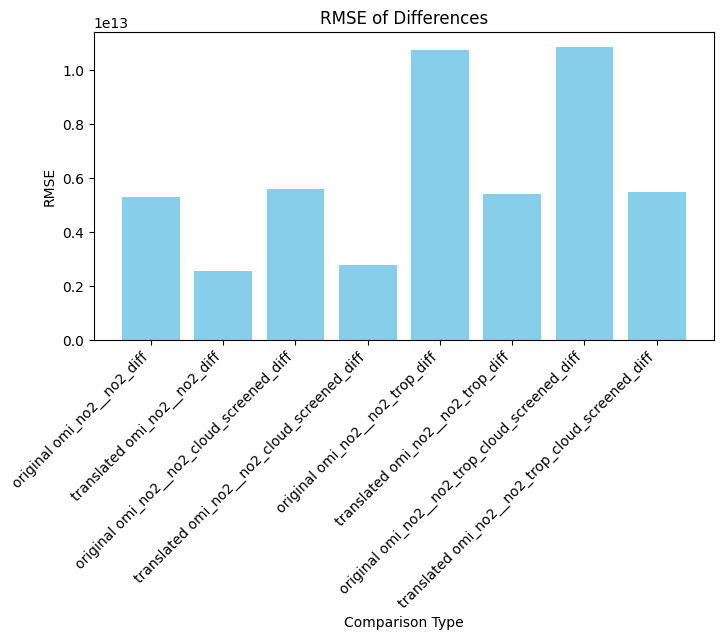

In [40]:
# Get the sum of the mean squared errors for each of these
mse_results = {
    "original omi_no2__no2_diff": (
        math.sqrt((original_diffs["omi_no2__no2_diff"] ** 2).mean()
        / original_diffs.shape[0])
    ),
    "translated omi_no2__no2_diff": (
        math.sqrt((omi_translated_joined_diffs["omi_no2__no2_diff"] ** 2).mean()
        / omi_translated_joined_diffs.shape[0])
    ),
    "original omi_no2__no2_cloud_screened_diff": (
        math.sqrt((original_diffs["omi_no2__no2_cloud_screened_diff"] ** 2).mean()
        / original_diffs.shape[0])
    ),
    "translated omi_no2__no2_cloud_screened_diff": (
        math.sqrt((omi_translated_joined_diffs["omi_no2__no2_cloud_screened_diff"] ** 2).mean()
        / omi_translated_joined_diffs.shape[0])
    ),
    "original omi_no2__no2_trop_diff": (
        math.sqrt((original_diffs["omi_no2__no2_trop_diff"] ** 2).mean()
        / original_diffs.shape[0])
    ),
    "translated omi_no2__no2_trop_diff": (
        math.sqrt((omi_translated_joined_diffs["omi_no2__no2_trop_diff"] ** 2).mean()
        / omi_translated_joined_diffs.shape[0])
    ),
    "original omi_no2__no2_trop_cloud_screened_diff": (
        math.sqrt((original_diffs["omi_no2__no2_trop_cloud_screened_diff"] ** 2).mean()
        / original_diffs.shape[0])
    ),
    "translated omi_no2__no2_trop_cloud_screened_diff": (
        math.sqrt((omi_translated_joined_diffs["omi_no2__no2_trop_cloud_screened_diff"] ** 2).mean()
        / omi_translated_joined_diffs.shape[0])
    ),
}

# Plot the MSE results
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(list(mse_results.keys()), list(mse_results.values()), color='skyblue')
ax.set_title("RMSE of Differences")
ax.set_xlabel('Comparison Type')
ax.set_ylabel('RMSE')
ax.set_xticks(range(len(mse_results)))
_ = ax.set_xticklabels(list(mse_results.keys()), rotation=45, ha='right')

Text(0.05, 0.9, 'RMSE = 7.62e14')

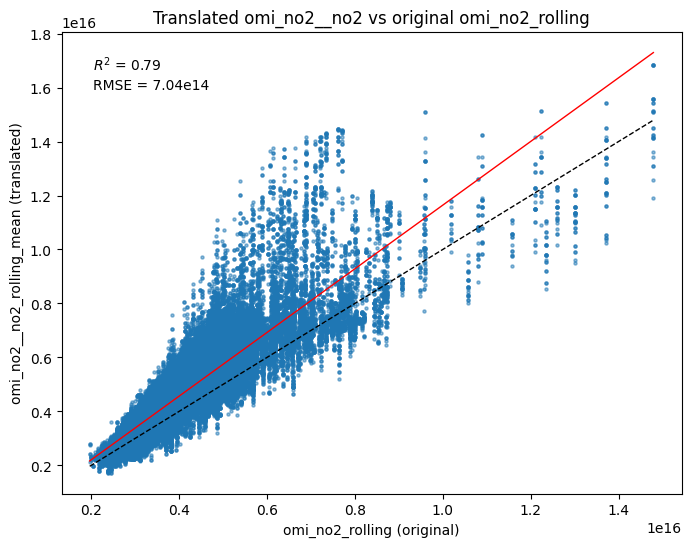

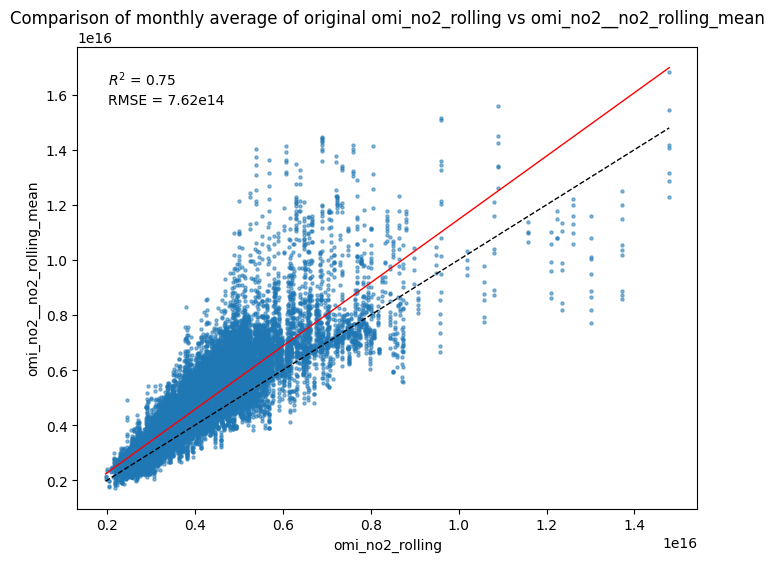

In [41]:
# plot omi_translated_joined omi_no2__no2 vs omi_no2 against each other

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    omi_translated_joined["omi_no2_rolling"],
    omi_translated_joined["omi_no2__no2_rolling_mean"],
    alpha=0.5,
    s=5,
)
ax.set_xlabel("omi_no2_rolling (original)")
ax.set_ylabel("omi_no2__no2_rolling_mean (translated)")
ax.set_title("Translated omi_no2__no2 vs original omi_no2_rolling")

final_comparison_xmin = omi_translated_joined["omi_no2_rolling"].min()
final_comparison_xmax = omi_translated_joined["omi_no2_rolling"].max()

# Add a line y=x
x_line = np.array([final_comparison_xmin, final_comparison_xmax])
y_line = x_line
ax.plot(x_line, y_line, color='black', linewidth=1, linestyle='--', label='y=x line')

    
slope, intercept = np.polyfit(omi_translated_joined["omi_no2_rolling"], omi_translated_joined["omi_no2__no2_rolling_mean"], 1)
x_line = np.array([final_comparison_xmin, final_comparison_xmax])
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='red', linewidth=1, label='Linear fit')

# Calculate R²
y_vals = omi_translated_joined["omi_no2__no2_rolling_mean"].to_numpy()
x_vals = omi_translated_joined["omi_no2_rolling"].to_numpy()
residuals = y_vals - (slope * x_vals + intercept)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_vals - np.mean(y_vals))**2)
r_squared = 1 - (ss_res / ss_tot)

# Annotate plot with R²
ax.text(0.05, 0.95, f"$R^2$ = {r_squared:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top')

# Calculate RMSE

rmse = math.sqrt(ss_res / len(y_vals))
ax.text(0.05, 0.90, f"RMSE = {rmse / 1e14:.2f}e14",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top')



### Compare this with the monthly average of the original

monthly_avg_omi_no2 = monthly_avg[["grid_id", "geometry", "omi_no2_rolling", "omi_no2__no2_rolling_mean"]]

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    monthly_avg_omi_no2["omi_no2_rolling"],
    monthly_avg_omi_no2["omi_no2__no2_rolling_mean"],
    alpha=0.5,
    s=5,
)
ax.set_xlabel("omi_no2_rolling")
ax.set_ylabel("omi_no2__no2_rolling_mean")
ax.set_title("Comparison of monthly average of original omi_no2_rolling vs omi_no2__no2_rolling_mean")

final_comparison_xmin = monthly_avg_omi_no2["omi_no2_rolling"].min()
final_comparison_xmax = monthly_avg_omi_no2["omi_no2_rolling"].max()

# Add a line y=x
x_line = np.array([final_comparison_xmin, final_comparison_xmax])
y_line = x_line
ax.plot(x_line, y_line, color='black', linewidth=1, linestyle='--', label='y=x line')
slope, intercept = np.polyfit(monthly_avg_omi_no2["omi_no2_rolling"], monthly_avg_omi_no2["omi_no2__no2_rolling_mean"], 1)
x_line = np.array([final_comparison_xmin, final_comparison_xmax])
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='red', linewidth=1, label='Linear fit')
# Calculate R²
y_vals = monthly_avg_omi_no2["omi_no2__no2_rolling_mean"].to_numpy()
x_vals = monthly_avg_omi_no2["omi_no2_rolling"].to_numpy()
residuals = y_vals - (slope * x_vals + intercept)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_vals - np.mean(y_vals))**2)
r_squared = 1 - (ss_res / ss_tot)
# Annotate plot with R²
ax.text(0.05, 0.95, f"$R^2$ = {r_squared:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top')

# Calculate RMSE
rmse = math.sqrt(ss_res / len(y_vals))
ax.text(0.05, 0.90, f"RMSE = {rmse / 1e14:.2f}e14",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top')

#### Results

It looks like:
- The dataset version 003 is correct.
- Ayako's version didn't account for centring the generated grid for OMI NO2.

However, I've still not accounted for some of the larger differences in the data,
especially in Mid-East India.

I've checked:
- There's only one version of the v003 dataset released for these months, so we
  shouldn't be working from a different dataset.